In [1]:
from pathlib import Path

import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ml.data import BuildingDataModule
from ml.surrogate import Surrogate
from tqdm.notebook import tqdm

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "latest"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.


In [3]:
dm = BuildingDataModule(
    bucket="ml-for-bem",
    remote_experiment="full_climate_zone/v7",
    data_dir="data/lightning",
    climate_experiment="weather/v1",
    batch_size=32,
    val_batch_mult=64,
)
dm.prepare_data()
dm.setup(stage=None)
unseen = dm.val_dataloader()[1]

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [4]:
surrogate.model.eval()

# create an empty dataframe with columns matching the target_transform.columns
df_preds = pd.DataFrame(columns=surrogate.target_transform.columns)
df_true = pd.DataFrame(columns=surrogate.target_transform.columns)


with torch.no_grad():
    i = 0
    for features, schedules, weather, targets in tqdm(unseen):
        features = features.cuda()
        schedules = schedules.cuda()
        weather = weather.cuda()
        targets = targets.cuda()
        preds = surrogate.model(features, schedules, weather)
        preds = preds.reshape(targets.shape)
        preds = surrogate.target_transform.inverse_transform(preds)
        targets = surrogate.target_transform.inverse_transform(targets)
        df_preds = pd.concat(
            [
                df_preds,
                pd.DataFrame(
                    preds.cpu().numpy(), columns=surrogate.target_transform.columns
                ),
            ],
            axis=0,
        )
        df_true = pd.concat(
            [
                df_true,
                pd.DataFrame(
                    targets.cpu().numpy(), columns=surrogate.target_transform.columns
                ),
            ],
            axis=0,
        )

        i += 1
        if i > 114:
            break
df_res = df_preds - df_true
mae = df_res.abs().mean(axis=0)
mbe = df_res.mean(axis=0)
mse = (df_res**2).mean(axis=0)
rmse = np.sqrt(mse)
cvrmse = rmse / df_true.mean(axis=0) * 100

df_preds_monthly_zones = df_preds.T.groupby(level=[0, 2]).sum().T
df_true_monthly_zones = df_true.T.groupby(level=[0, 2]).sum().T
df_res_monthly_zones = df_preds_monthly_zones - df_true_monthly_zones

mse_monthly_zones = (df_res_monthly_zones**2).mean(axis=0)
mae_monthly_zones = df_res_monthly_zones.abs().mean(axis=0)
rmse_monthly_zones = np.sqrt(mse_monthly_zones)
cvrmse_monthly_zones = rmse_monthly_zones / df_true_monthly_zones.mean(axis=0) * 100


df_preds_annual = df_preds.T.groupby(by=["KeyValue", "Name"]).sum().T
df_true_annual = df_true.T.groupby(by=["KeyValue", "Name"]).sum().T
df_res_annual = df_preds_annual - df_true_annual

# compute mae mse rmse cvrmse for annual
mae_annual = df_res_annual.abs().mean(axis=0)
mse_annual = (df_res_annual**2).mean(axis=0)
rmse_annual = np.sqrt(mse_annual)
cvrmse_annual = rmse_annual / df_true_annual.mean(axis=0) * 100

  0%|          | 0/57 [00:00<?, ?it/s]

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


In [5]:
monthly_cvrmse_by_zone = (
    np.sqrt((df_res_monthly_zones**2).mean(axis=0).groupby(level=0).mean())
    / df_true_monthly_zones.mean(axis=0).groupby(level=0).mean()
    * 100
)
monthly_cvrmse_by_zone

KeyValue
Core         6.879674
Perimeter    6.301668
dtype: float32

In [6]:
(df_res.abs().T.groupby(level=[0, 1]).mean().T).describe()

KeyValue           Core                     Perimeter               
Name            Cooling        Heating        Cooling        Heating
count     115740.000000  115740.000000  115740.000000  115740.000000
mean           0.243627       0.111713       0.403965       0.203000
std            0.290615       0.211963       0.464996       0.310036
min            0.006225       0.002603       0.006098       0.002525
25%            0.097061       0.017578       0.147227       0.020363
50%            0.161142       0.027209       0.260375       0.074453
75%            0.284879       0.123122       0.484314       0.267038
max           16.454723       4.072316      21.904289       7.027847

## Annual Plots

C:\Users\szvsw\AppData\Local\Temp\ipykernel_3316\1724849414.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


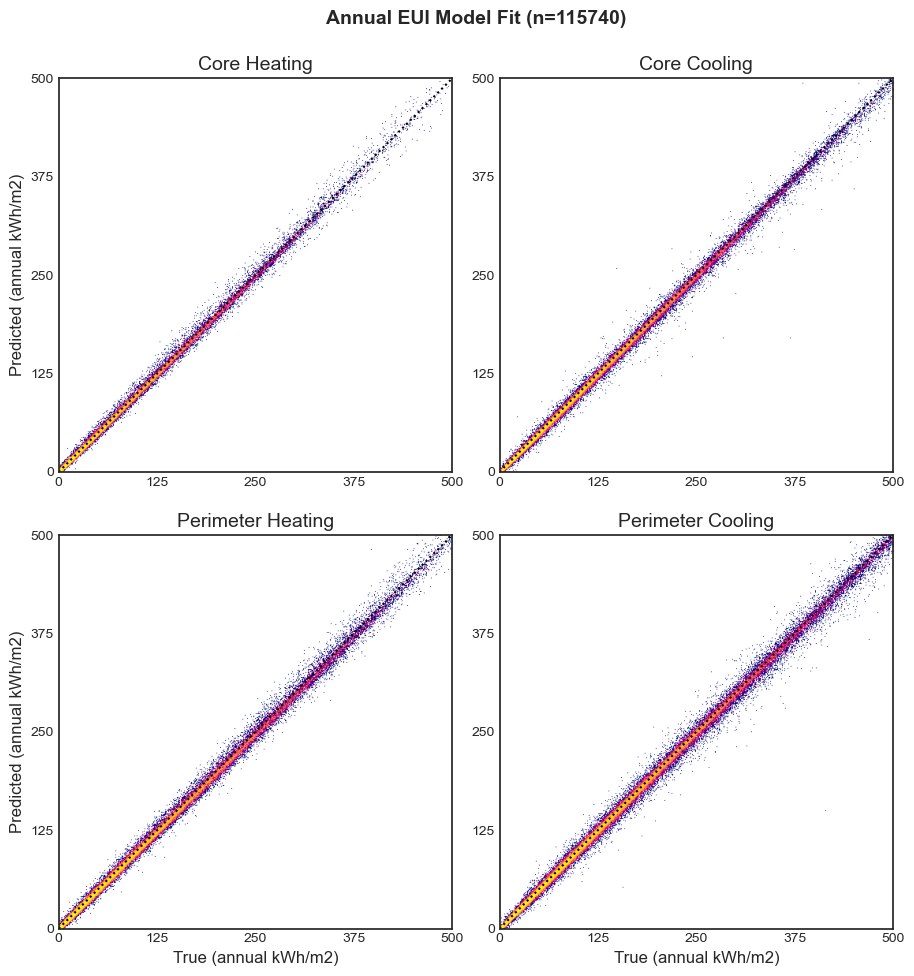

In [7]:
save = False
# bring df_res, df_preds, df_true into a single dataframe, which has the same columns but a new top level in the multi index
df = pd.concat(
    [df_res_annual, df_preds_annual, df_true_annual],
    keys=["res", "preds", "true"],
    axis=1,
)

# convert df column names to a flat set of strings
df.columns = df.columns.map("_".join)

# plt.style.use("dark_background")
# plt.style.use("default")
plt.style.use("seaborn-white")
plt.rcParams["font.family"] = "sans serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams["axes.titleweight"] = "light"
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["figure.subplot.bottom"] = 0.4

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
bg_color, cmap = "#202020", cc.bmy
bg_color, cmap = "#ffffff", cc.blues
bg_color, cmap = "#ffffff", cc.fire
bg_color, cmap = "#ffffff", cc.bmy
fig.patch.set_facecolor(bg_color)
# create a datashader canvas
limits = 500
res = 500
cvs = ds.Canvas(
    plot_width=res,
    plot_height=res,
    x_range=(0, limits),
    y_range=(0, limits),
)
# create a scatterplot of the data
i = 0
for zone in ["Core", "Perimeter"]:
    j = 0
    for end_use in ["Heating", "Cooling"]:

        agg = cvs.points(df, (f"true_{zone}_{end_use}"), (f"preds_{zone}_{end_use}"))
        shader = ds.tf.shade(agg, cmap=cmap)
        # create a line from 0,0 to max of df[true_{zone}_{end_use}]
        # line = pd.DataFrame({"x":[0, df[f"true_{zone}_{end_use}"].max()], "y":[0, df[f"true_{zone}_{end_use}"].max()]})
        # line_agg = cvs.line(line, "x","y")
        # shade the line
        # line_shader = ds.tf.shade(line_agg, cmap="white")
        # stack the line on top of the scatterplot
        # shader = ds.tf.stack(shader, line_shader)
        im = ds.tf.set_background(shader, bg_color, f"{zone}_{end_use}")
        im = im.to_pil()
        if save:
            im.save(f"figures/true_vs_preds_{zone}_{end_use}.png")
        # plot im upside down
        axs[i, j].imshow(np.flipud(im), origin="lower")
        axs[i, j].set_title(f"{zone} {end_use}")
        axs[i, j].plot(
            [0, res], [0, res], ":", color="white" if bg_color != "#ffffff" else "black"
        )
        j = j + 1
    i = i + 1
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks(
            np.linspace(0, res, 5).astype(int), np.linspace(0, limits, 5).astype(int)
        )
        axs[i, j].set_yticks(
            np.linspace(0, res, 5).astype(int), np.linspace(0, limits, 5).astype(int)
        )
        if j == 0:
            axs[i, j].set_ylabel("Predicted (annual kWh/m2)")
        if i == 1:
            axs[i, j].set_xlabel("True (annual kWh/m2)")
        axs[i, j].set_xlim(0, limits)
        axs[i, j].set_ylim(0, limits)
fig.suptitle(f"Annual EUI Model Fit (n={len(df)})")
fig.tight_layout()

## Monthly Plots

C:\Users\szvsw\AppData\Local\Temp\ipykernel_3316\536917325.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


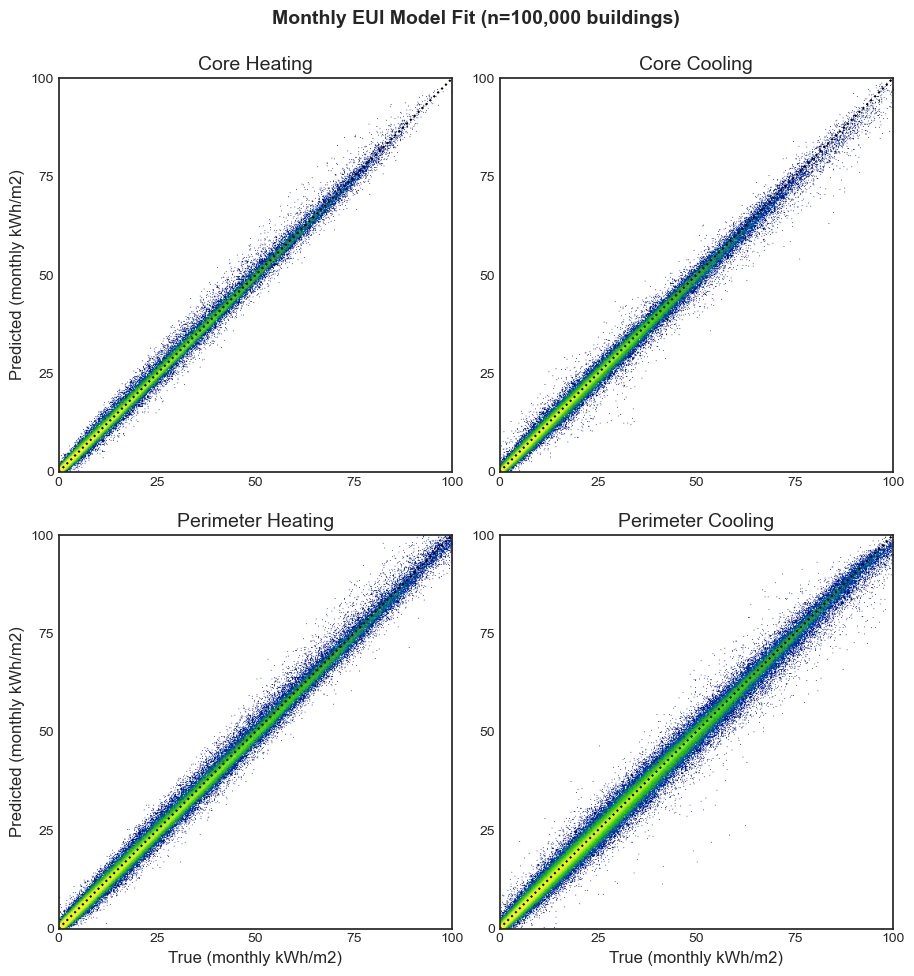

In [8]:
save = False
# bring df_res, df_preds, df_true into a single dataframe, which has the same columns but a new top level in the multi index
df = pd.concat([df_res, df_preds, df_true], keys=["res", "preds", "true"], axis=1)
# melt the df
df = df.stack(level=-1)
df = df.reset_index(names=["sample_id", "Month"])

# convert df column names to a flat set of strings
df.columns = df.columns.map("_".join)

# plt.style.use("dark_background")
# plt.style.use("default")
plt.style.use("seaborn-white")

plt.rcParams["font.family"] = "sans serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams["axes.titleweight"] = "light"
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["figure.subplot.bottom"] = 0.4

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
bg_color, cmap = "#202020", cc.bmy
bg_color, cmap = "#ffffff", cc.fire
bg_color, cmap = "#ffffff", cc.bmy
bg_color, cmap = "#ffffff", cc.blues
bg_color, cmap = "#ffffff", cc.bgy
fig.patch.set_facecolor(bg_color)

# create a datashader canvas
res = 500
limits = 100
cvs = ds.Canvas(
    plot_width=res,
    plot_height=res,
    x_range=(0, limits),
    y_range=(0, limits),
)
# create a scatterplot of the data
i = 0
for zone in ["Core", "Perimeter"]:
    j = 0
    for end_use in ["Heating", "Cooling"]:

        agg = cvs.points(df, (f"true_{zone}_{end_use}"), (f"preds_{zone}_{end_use}"))
        shader = ds.tf.shade(agg, cmap=cmap)
        # create a line from 0,0 to max of df[true_{zone}_{end_use}]
        # line = pd.DataFrame({"x":[0, df[f"true_{zone}_{end_use}"].max()], "y":[0, df[f"true_{zone}_{end_use}"].max()]})
        # line_agg = cvs.line(line, "x","y")
        # shade the line
        # line_shader = ds.tf.shade(line_agg, cmap="white")
        # stack the line on top of the scatterplot
        # shader = ds.tf.stack(shader, line_shader)
        im = ds.tf.set_background(shader, bg_color, f"{zone}_{end_use}")
        im = im.to_pil()
        if save:
            im.save(f"figures/true_vs_preds_{zone}_{end_use}.png")
        # plot im upside down
        axs[i, j].imshow(np.flipud(im), origin="lower")
        axs[i, j].set_title(f"{zone} {end_use}")
        axs[i, j].plot(
            [0, res], [0, res], ":", color="white" if bg_color != "#ffffff" else "black"
        )
        j = j + 1
    i = i + 1
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks(
            np.linspace(0, res, 5).astype(int), np.linspace(0, limits, 5).astype(int)
        )
        axs[i, j].set_yticks(
            np.linspace(0, res, 5).astype(int), np.linspace(0, limits, 5).astype(int)
        )
        if i == 1:
            axs[i, j].set_xlabel("True (monthly kWh/m2)")
        if j == 0:
            axs[i, j].set_ylabel("Predicted (monthly kWh/m2)")
        axs[i, j].set_xlim(0, res)
        axs[i, j].set_ylim(0, res)
fig.suptitle(
    f"Monthly EUI Model Fit (n={int(len(df)/12//100_000 * 100_000):,d} buildings)"
)
fig.tight_layout()

## Monthly Arc Plots

  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\szvsw\AppData\Local\Temp\ipykernel_44624\3149040313.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8, 4.5))


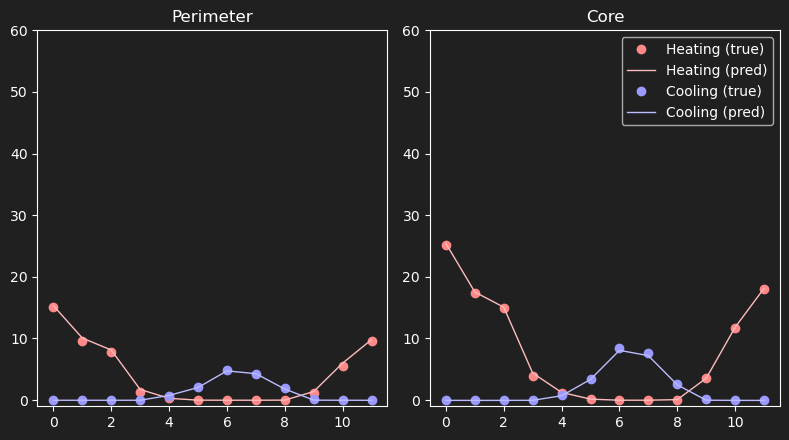

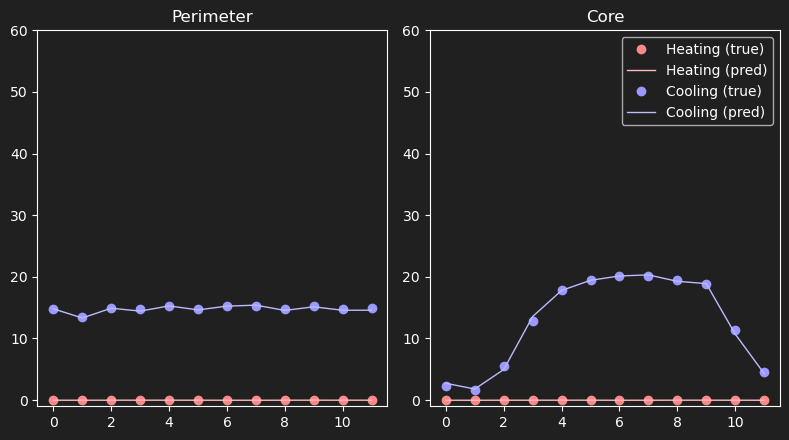

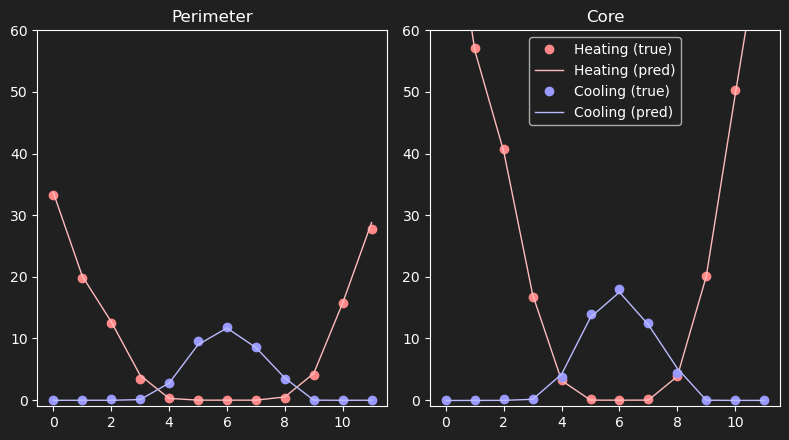

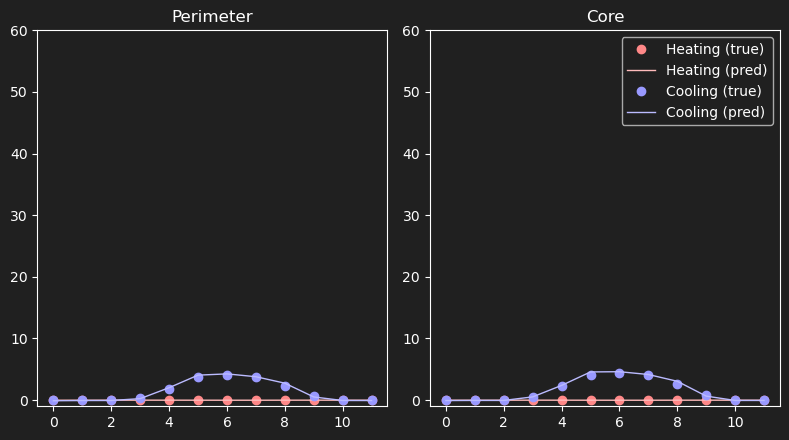

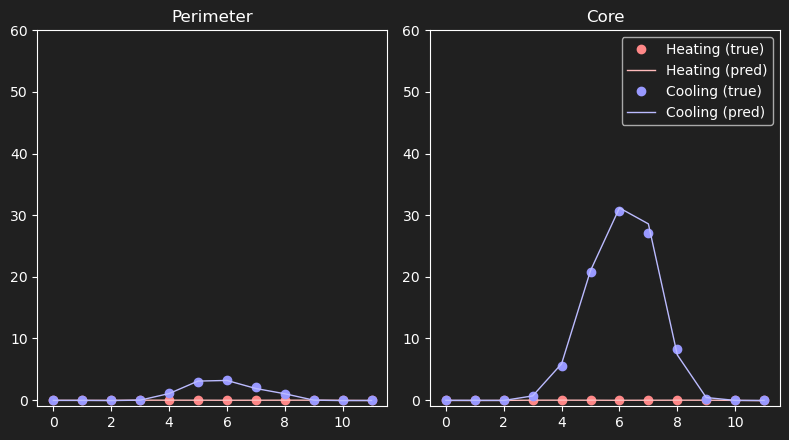

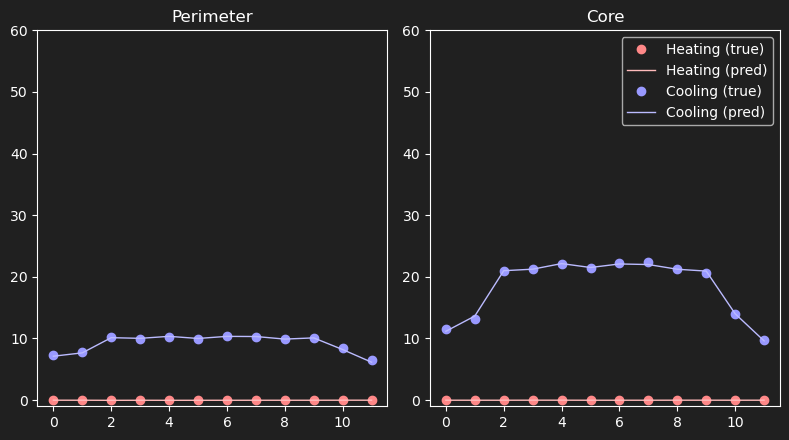

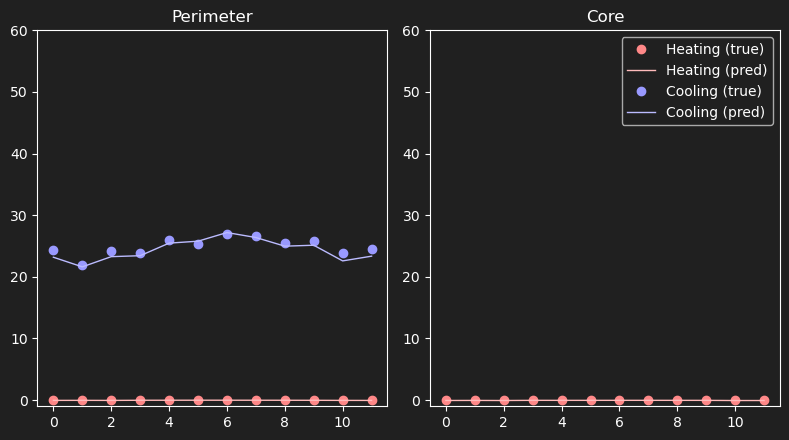

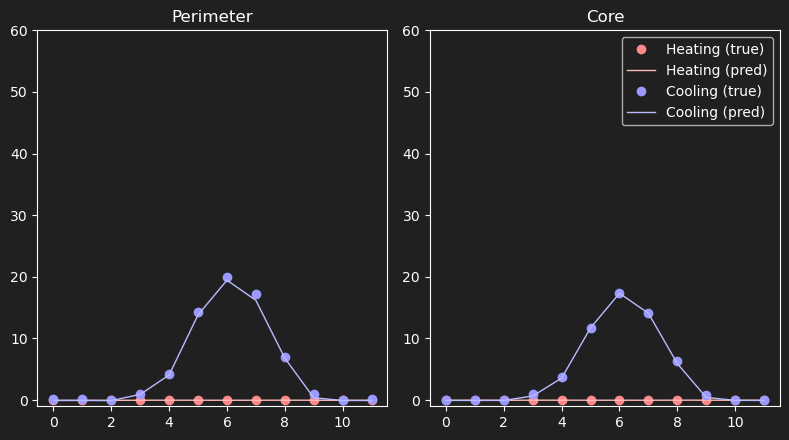

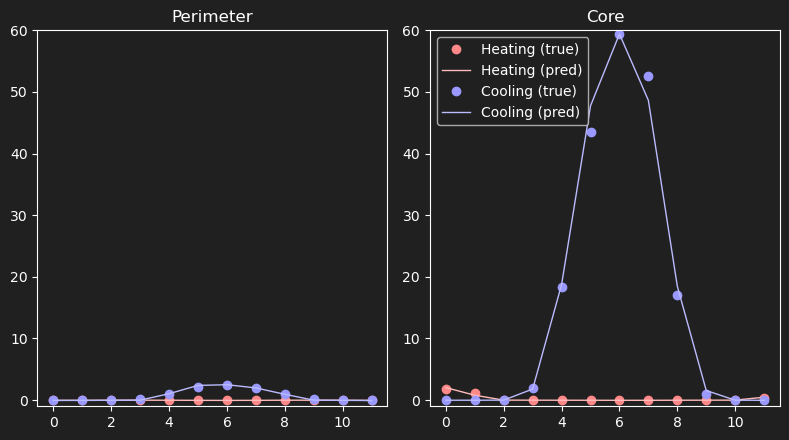

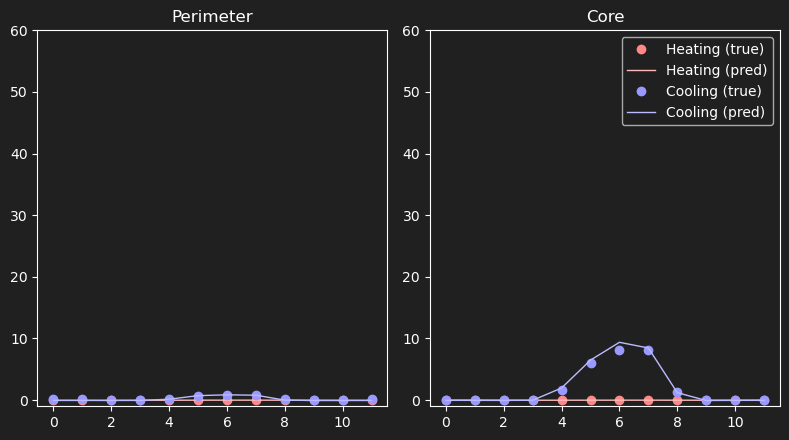

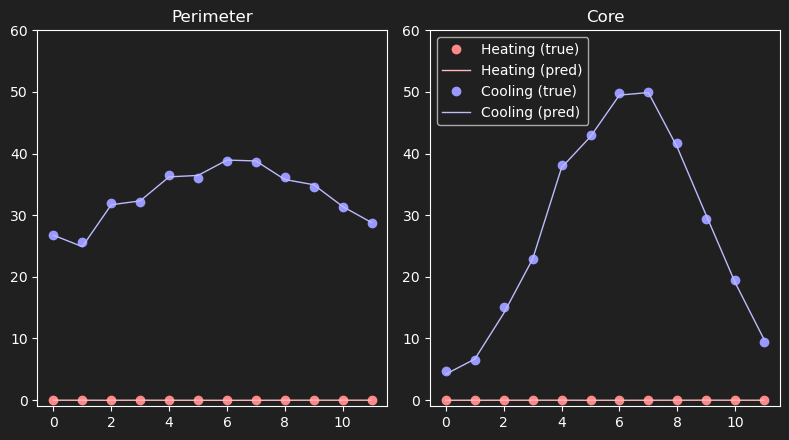

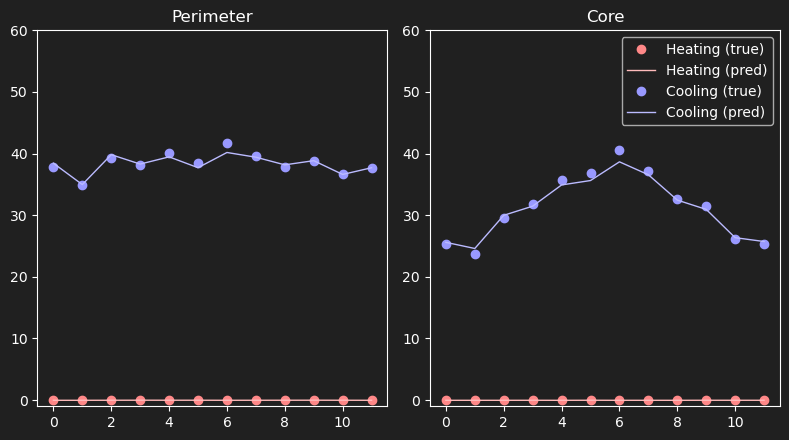

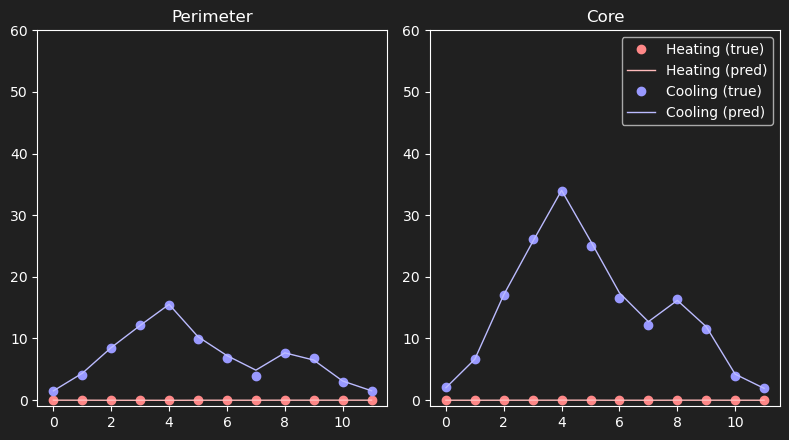

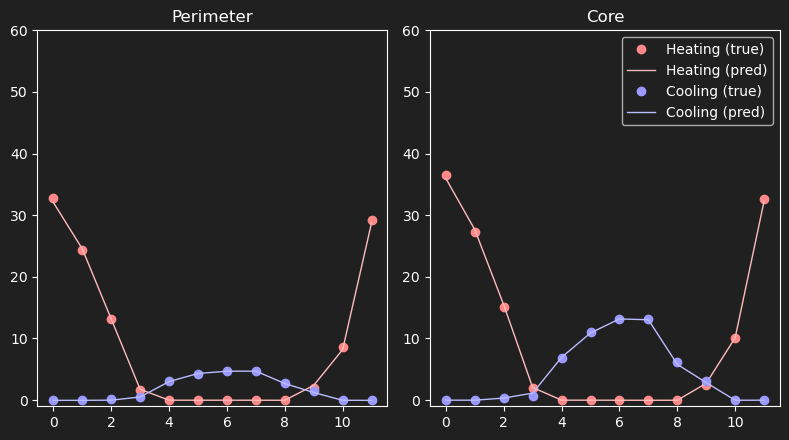

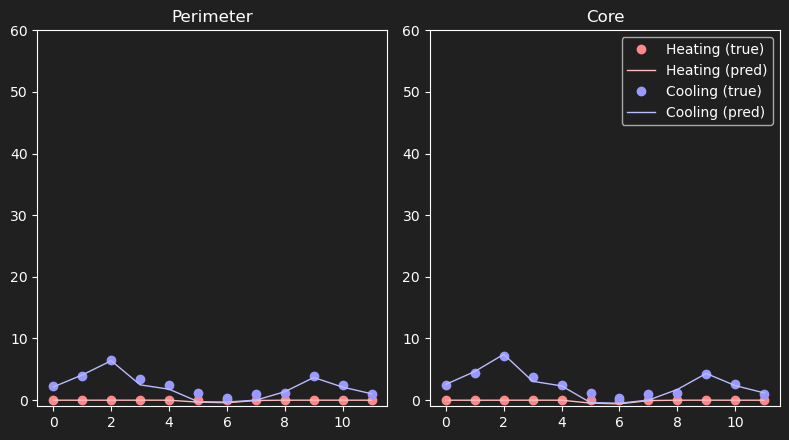

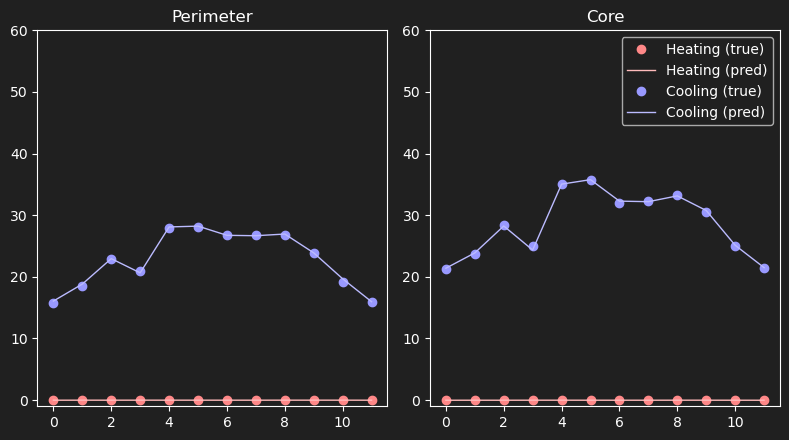

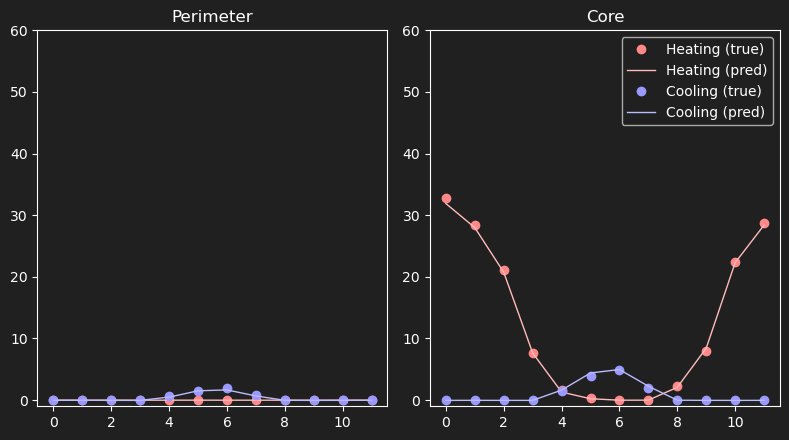

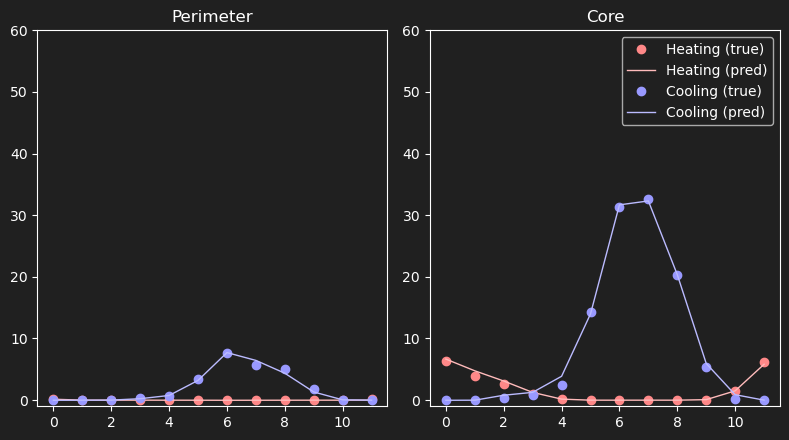

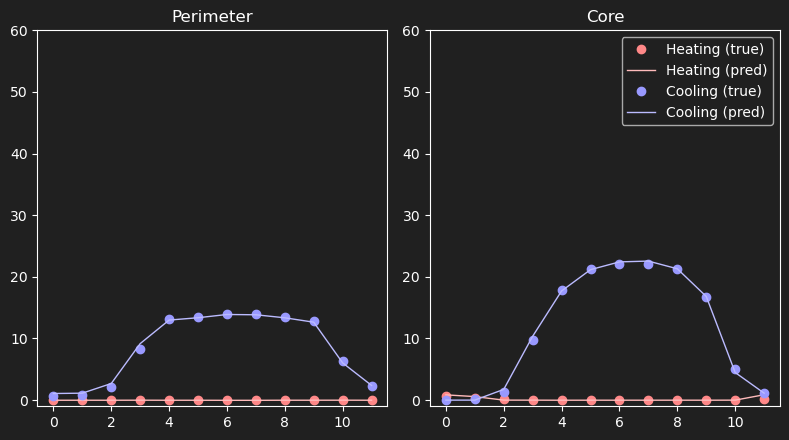

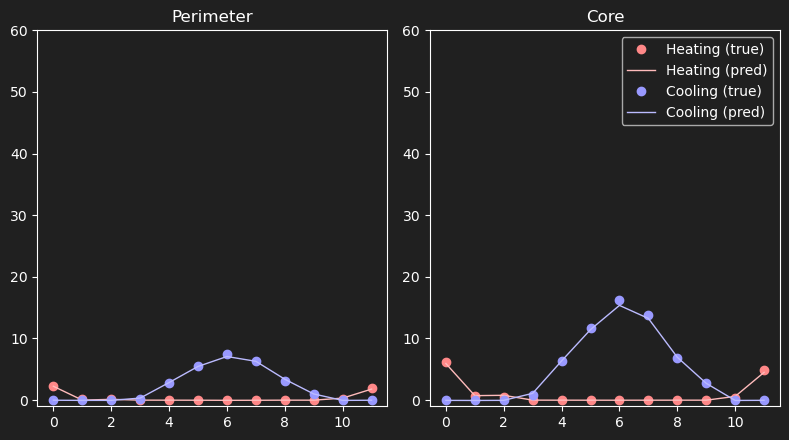

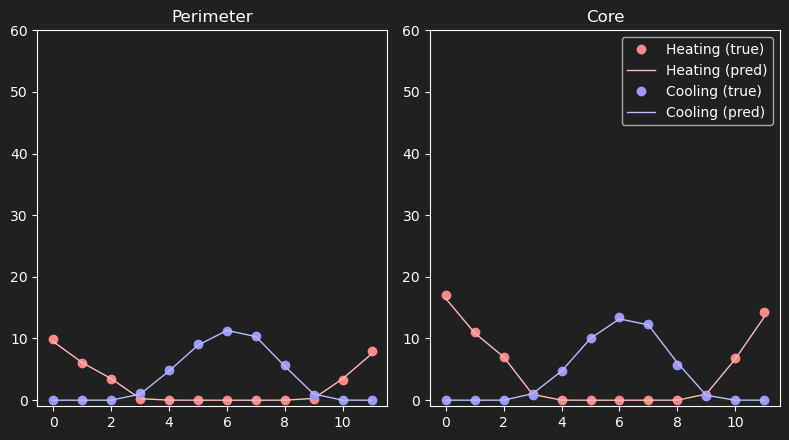

In [11]:
import torch

surrogate.model.eval()
import matplotlib.pyplot as plt

plt.style.use("dark_background")
# set plt background to #202020
plt.rcParams["axes.facecolor"] = "#202020"
plt.rcParams["figure.facecolor"] = "#202020"
errs = []
ct = 0
with torch.no_grad():
    i = 0
    for features, schedules, weather, targets in tqdm(unseen):
        features = features.cuda()
        schedules = schedules.cuda()
        weather = weather.cuda()
        targets = targets.cuda()
        preds = surrogate.model(features, schedules, weather)
        hier_shape = preds.shape
        preds = preds.reshape(targets.shape)
        preds = surrogate.target_transform.inverse_transform(preds)
        targets = surrogate.target_transform.inverse_transform(targets)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds = preds.reshape(hier_shape)
        targets = targets.reshape(hier_shape)
        for samp in range(len(preds)):
            ct = ct + 1
            fig, axs = plt.subplots(1, 2, figsize=(8, 4.5))
            j = 0
            for zone in ["Perimeter", "Core"]:
                k = 0
                for end_use in ["Heating", "Cooling"]:
                    ax = axs[j]
                    ix = 2 * j + k
                    ax.set_title(f"{zone}")
                    ax.plot(
                        targets[samp, ix],
                        "o",
                        label=f"{end_use} (true)",
                        color="#ff8888" if end_use == "Heating" else "#9999ff",
                    )
                    ax.plot(
                        preds[samp, ix],
                        label=f"{end_use } (pred)",
                        lw=1,
                        color="#ffbbbb" if end_use == "Heating" else "#bbbbff",
                    )
                    ax.set_ylim(-1, 60)

                    k = k + 1
                j = j + 1

            plt.legend()
            fig.tight_layout()
            if ct > 20:
                break
        break

## By CZ

In [36]:
len(unseen), len(unseen.dataset), len(unseen.dataset.dataset)

(57, 115740, 231480)

In [37]:
from utils.constants import EPW_MAP_PATH, EPW_RELATIVE_PATH, EPW_TESTING_LIST_PATH
from utils.nrel_uitls import CLIMATEZONES, CLIMATEZONES_LIST

n_samps = len(df_res)
samp_ixs = unseen.dataset.indices
assert n_samps == len(samp_ixs)
epw_ixs = unseen.dataset.dataset.epw_ixs.iloc[samp_ixs]
czs = pd.read_csv(EPW_TESTING_LIST_PATH).set_index("idx").loc[epw_ixs, "CZ"]
data = pd.concat(
    [df_res, df_preds, df_true],
    keys=["res", "preds", "true"],
    axis=1,
    names=["segment"],
)
data = data.set_index(czs, append=True)
squared_error = data["res"].pow(2)
mean_squared_error_by_cz_and_zone = (
    squared_error.groupby("CZ").mean().T.groupby(level=[0, 1]).mean().T
).sort_index()
true_mean_by_cz_and_zone = (
    data["true"].groupby("CZ").mean().T.groupby(level=[0, 1]).mean().T
).sort_index()

rmse_by_cz_and_zone = mean_squared_error_by_cz_and_zone.pow(0.5)
cvrmse_by_cz_and_zone = rmse_by_cz_and_zone / true_mean_by_cz_and_zone * 100
mbe_by_cz_and_zone = data["res"].stack(level=-1).groupby("CZ").mean()
nmbe_by_cz_and_zone = mbe_by_cz_and_zone / true_mean_by_cz_and_zone * 100
mae_by_cz_and_zone = data["res"].abs().stack(level=-1).groupby("CZ").mean()

cvrmse_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="w", key="cvrmse_by_cz_and_zone"
)
rmse_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="rmse_by_cz_and_zone"
)
mbe_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="mbe_by_cz_and_zone"
)
nmbe_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="nmbe_by_cz_and_zone"
)
mae_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="mae_by_cz_and_zone"
)


annual_res = data["res"].T.groupby(["KeyValue", "Name"]).sum().T
annual_squared_error = annual_res.pow(2)
annual_mean_squared_error_by_cz_and_zone = (
    annual_squared_error.groupby("CZ").mean()
).sort_index()
annual_rmse_by_cz_and_zone = annual_mean_squared_error_by_cz_and_zone.pow(0.5)
annual_true_mean_by_cz_and_zone = (
    data["true"].T.groupby(["KeyValue", "Name"]).sum().T.groupby("CZ").mean()
).sort_index()
annual_cvrmse_by_cz_and_zone = (
    annual_rmse_by_cz_and_zone / annual_true_mean_by_cz_and_zone * 100
).sort_index()
annual_mae_by_cz_and_zone = annual_res.abs().groupby("CZ").mean().sort_index()
annual_mbe_by_cz_and_zone = annual_res.groupby("CZ").mean().sort_index()
annual_nmbe_by_cz_and_zone = (
    annual_mbe_by_cz_and_zone / annual_true_mean_by_cz_and_zone * 100
).sort_index()
annual_cvrmse_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="annual_cvrmse_by_cz_and_zone"
)
annual_rmse_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="annual_rmse_by_cz_and_zone"
)
annual_mae_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="annual_mae_by_cz_and_zone"
)
annual_mbe_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="annual_mbe_by_cz_and_zone"
)
annual_nmbe_by_cz_and_zone.to_hdf(
    "unseen-shoebox-results.hdf", mode="a", key="annual_nmbe_by_cz_and_zone"
)